Autocorrelation to see if they are truly bimodal
Use the MAP for the main graph. Highest probability chain.
Try to run without MAP

In [1]:
%matplotlib inline
import numpy as np
import theano.tensor as tt
import pymc3 as pm
from scipy import stats
from pymc3 import Continuous
from theano import tensor 
from pymc3 import Model, Normal, Slice
from pymc3 import sample
from pymc3 import traceplot
from pymc3.distributions import Interpolated
from theano import as_op
import theano.tensor as tt
import numpy as np
from scipy import stats
import threading
from multiprocessing.pool import ThreadPool
from astropy.table import Table
#exp, log, sqrt

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))
core_count = 20

Running on PyMC3 v3.8


In [2]:
def SuperNova_CurveRise_Scalar(t, A, B, t0, trise, scalar):
    return ((A+B*(t-t0))/(1+np.exp(-(t-t0)/trise)))+scalar
def SuperNova_CurveFall_Scalar(t, A, B, t0, gamma, trise, tfall, scalar):
    return (A + B*((gamma+t0)-t0))*np.exp(-(t-(gamma+t0))/tfall)/(1+np.exp(-(t-t0)/trise))+scalar

In [3]:
def SuperNova_CurveRise(t, A, B, t0, trise):
    return ((A+B*(t-t0))/(1+np.exp(-(t-t0)/trise)))
def SuperNova_CurveFall(t, A, B, t0, gamma, trise, tfall):
    return (A + B*((gamma+t0)-t0))*np.exp(-(t-(gamma+t0))/tfall)/(1+np.exp(-(t-t0)/trise))

In [4]:
def from_posteriors(param, samples):
    smins = []
    smaxs = []
    for i in samples:
        smins.append(np.min(i[param]))
        smaxs.append(np.max(i[param]))
    
    smin = np.min(smins)
    smax = np.max(smaxs)
    width = smax - smin

    x = np.linspace(smin, smax, 1000)
    ys = []
    for i in samples:
        ys.append(stats.gaussian_kde(i[param])(x))
    y = np.prod(ys, axis = 0)
    return Interpolated(param, x, y)

In [5]:
def from_posterior(param, samples):
    smin, smax = np.min(samples[param]), np.max(samples[param])
    width = smax - smin
    x = np.linspace(smin, smax, 1000)
    y = stats.gaussian_kde(samples[param])(x)
    return Interpolated(param, x, y)

In [6]:
def make_curve(param, samples):
    smins = []
    smaxs = []

    for i in samples:
        smins.append(np.min(i[param]))
        smaxs.append(np.max(i[param]))

    

    smin = np.min(smins)
    smax = np.max(smaxs)
    width = smax - smin

    x, step = np.linspace(smin, smax, 1000, retstep = True)
    ys = []
    for i in samples:
        ys.append(stats.gaussian_kde(i[param])(x))
    y = np.prod(ys, axis = 0)
    y = y + np.exp(-100)
    y_norm = y / (np.sum(y)*step)
    return param, x, y_norm
def make_prior(posterior_param):
    return Interpolated(posterior_param[0],posterior_param[1],posterior_param[2])

In [7]:
def model_run(model,i,trace, iterations, core):
    with model:
        # 10000 posterior samples
        trace[i] = pm.sample(iterations, cores = core)

In [8]:
ztf_data = Table.read("/home/xjh0560/Supernova_Lightcurves/flux_obs_19yvq.csv")

In [9]:
filter_types = np.unique(ztf_data["filt"])[3:6]
filter_number = np.size(filter_types)

In [10]:
end_A = np.max(ztf_data["t_restframe"])

In [11]:
#This is the test data we are going to use for a test
time_axis_filters = []
Y_observed_filter = []
Y_unc = []
scale = 1000000
ztf_data = ztf_data[3:-1]
for i in filter_types:
    print(i)
    time_axis_filters.append(np.asarray(ztf_data["t_restframe"][np.where(ztf_data["filt"] == i)]))
    light_data = np.asarray(ztf_data["flux_Jy"][np.where(ztf_data["filt"] == i)])
    Y_observed_filter.append(light_data * scale)
    light_data_unc = np.asarray(ztf_data["flux_unc_Jy"][np.where(ztf_data["filt"] == i)])
    Y_unc.append(light_data_unc * scale)

g
i
r


Text(0.5, 1.0, 'Observed Light Curve')

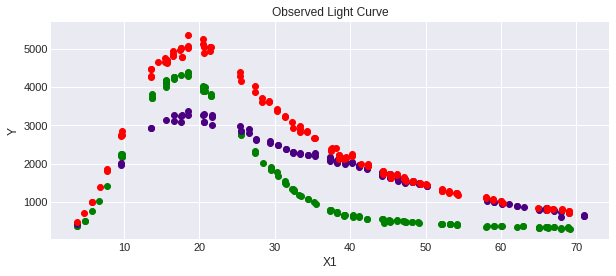

In [12]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,4))
colours = ["green", "indigo", "red"]
for i in range(filter_number):
    #axes.scatter(time_axis_filters[i], Y_observed_filter[i], color = colours[i])
    axes.errorbar(time_axis_filters[i], Y_observed_filter[i], Y_unc[i], fmt = "o", color = colours[i])

axes.set_ylabel('Y')
axes.set_xlabel('X1')
plt.title("Observed Light Curve")

In [13]:
model_filters = []
for i in range(filter_number):
    model_filters.append(pm.Model())

In [14]:
for i in range(filter_number):
    with model_filters[i]:

        # Priors for unknown model parameters

        trise = pm.Uniform('trise', lower = 0.01, upper = 50)
        tfall = pm.Uniform('tfall', lower = 1, upper = 300)
        
        Amp_Guess = np.max(Y_observed_filter[i])-np.min(Y_observed_filter[i])
        Amplitude = pm.Normal('Amplitude', mu=Amp_Guess, sigma=Amp_Guess/2)
        
        Beta = pm.Uniform('Beta', lower = -np.max(Y_observed_filter[i]), upper = 0)
        
        location_high = time_axis_filters[i][np.argmax(Y_observed_filter[i])]
        t0 = pm.Uniform('t0', lower = 0, upper = location_high)
        
        sigma_est = np.sqrt(np.sum(Y_unc[i]**2))
        sigma = pm.HalfNormal('sigma', sigma=sigma_est)
        
        limits = np.absolute(np.max(Y_observed_filter[i]))
        scalar = pm.Uniform('scalar', lower = -limits, upper = limits)

        #gamma = pm.Uniform('gamma', lower = np.min(time_axis), upper = np.max(time_axis), testval = (least_slope[0]-))
        no_p = pm.Normal.dist(mu = 5, sigma = 5)
        yes_p = pm.Normal.dist(mu = 60, sigma = 30)

        gamma = pm.Mixture("gamma", w=[2/3,1/3], comp_dists = [no_p, yes_p])
        #gamma = pm.math.sum(pm.Normal("no_p", mu = 5, sigma = 5),pm.Normal("yes_p", mu = 60, sigma = 30))

        # Expected value of outcome
        mu_rise = SuperNova_CurveRise_Scalar(time_axis_filters[i], Amplitude, Beta, t0, trise, scalar)
        mu_fall = SuperNova_CurveFall_Scalar(time_axis_filters[i], Amplitude, Beta, t0, gamma, trise, tfall, scalar)

        mu_switch = pm.math.switch(gamma+t0 >= time_axis_filters[i], mu_rise, mu_fall)

        # Likelihood (sampling distribution) of observations
        Y_obs = pm.Normal('Y_obs', mu=mu_switch, sigma=sigma, observed=Y_observed_filter[i])
    
    

In [15]:
trace = []
for basic_model in model_filters:
    with basic_model:
        # 10000 posterior samples
        iterations = 10000
        tune_i = int(iterations/2)
        #start = pm.find_MAP(model=basic_model)
        trace.append(pm.sample(iterations, tune = tune_i, cores = core_count))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (20 chains in 20 jobs)
NUTS: [gamma, scalar, sigma, t0, Beta, Amplitude, tfall, trise]
Sampling 20 chains, 397 divergences: 100%|██████████| 300000/300000 [03:25<00:00, 1460.95draws/s]
The acceptance probability does not match the target. It is 0.8826878395627145, but should be close to 0.8. Try to increase the number of tuning steps.
There were 309 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.558728154162352, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.72075515726248, but should be close to 0.8. Try to increase the number of tuning steps.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The accepta

There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
There were 448 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.648277051740157, but should be close to 0.8. Try to increase the number of tuning steps.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
There were 738 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.685157555381378, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


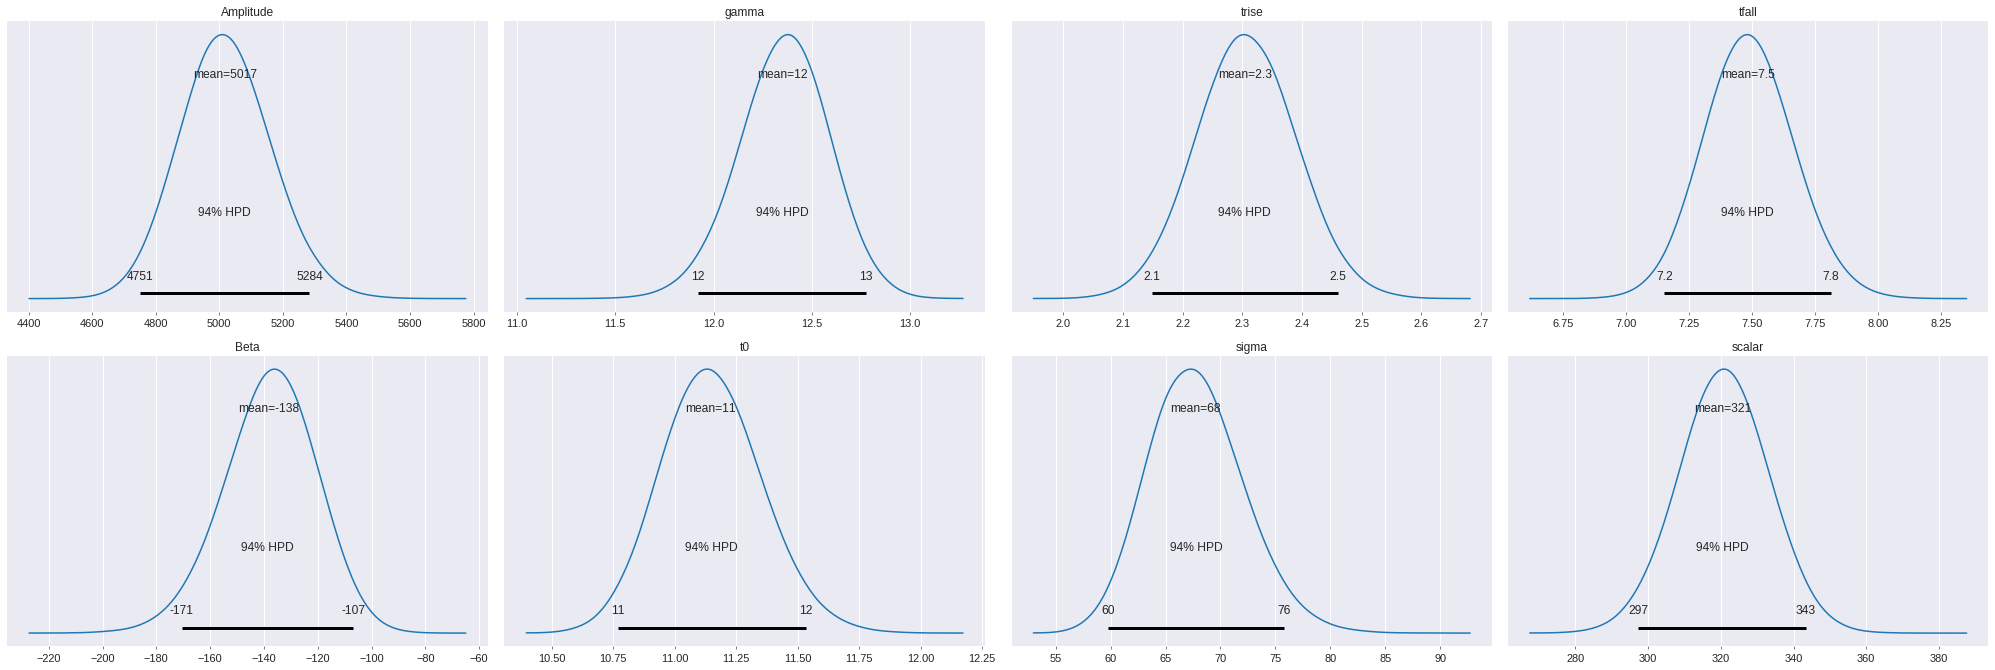

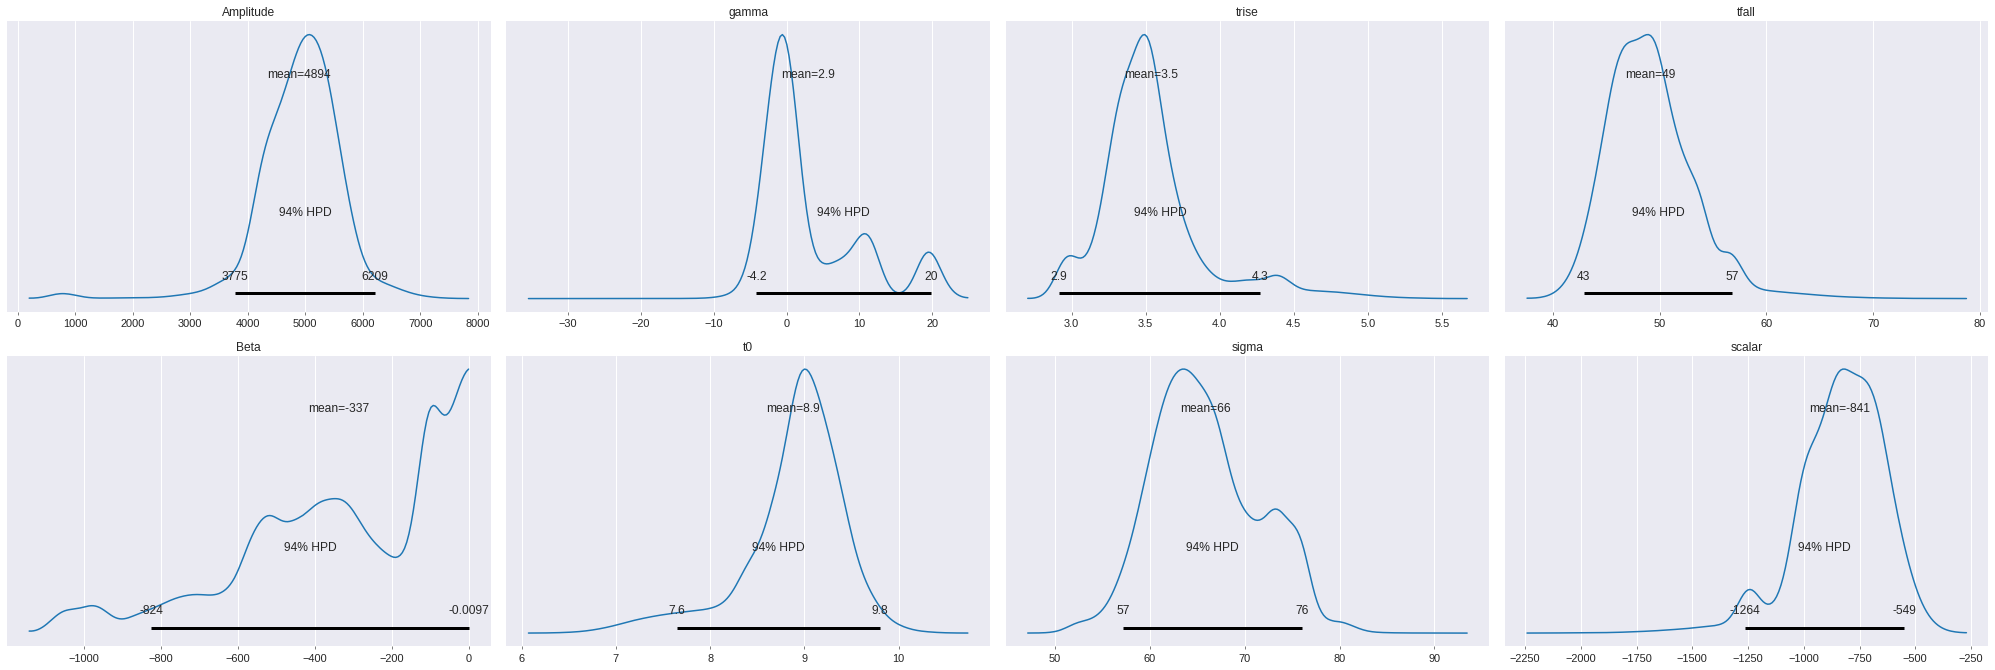

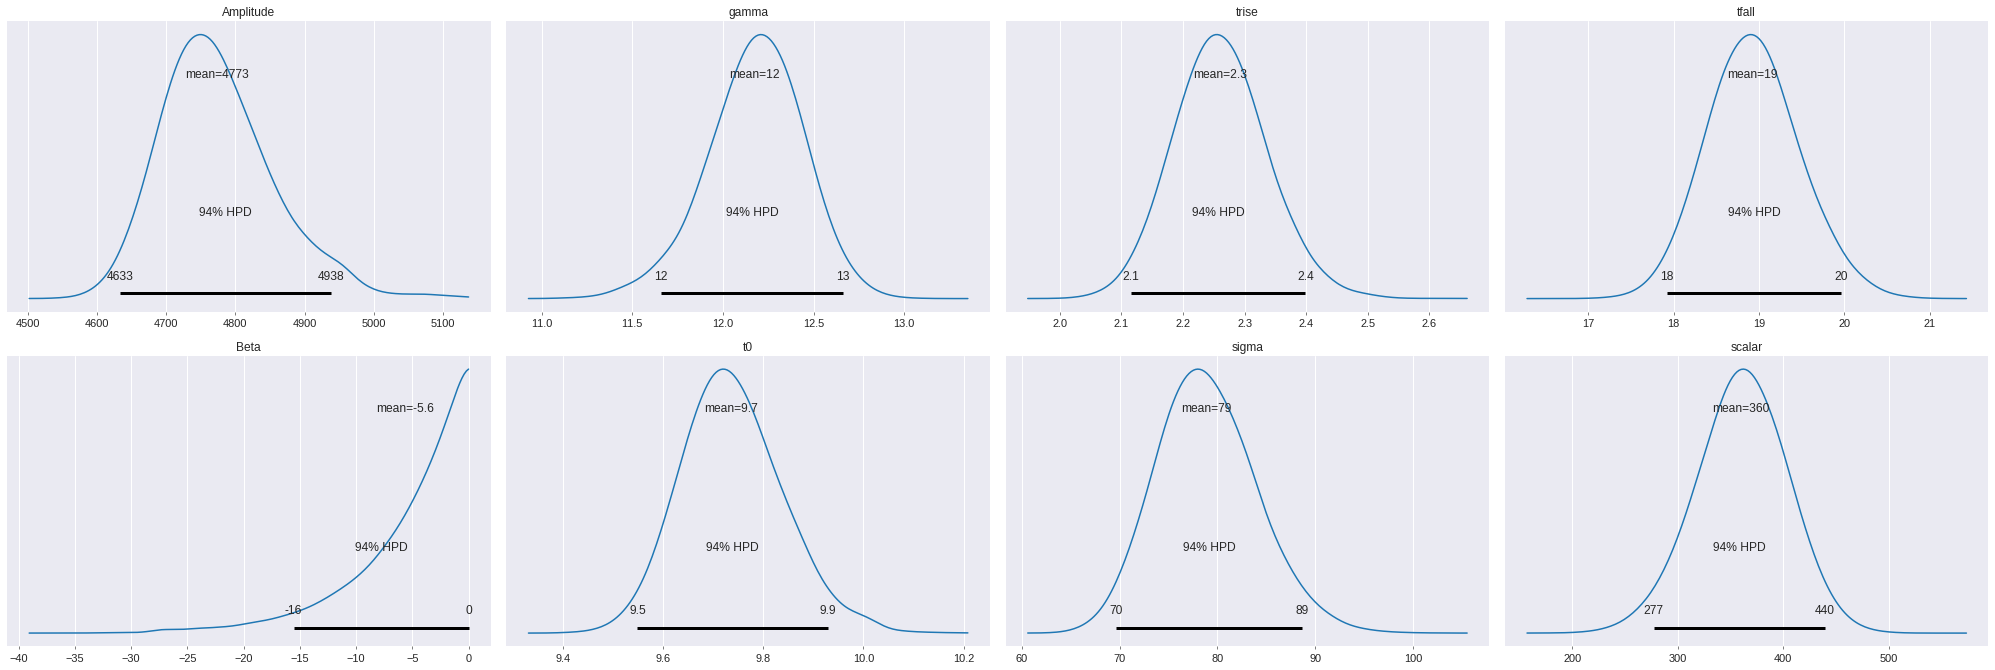

In [16]:
for posterior in trace:
    pm.plot_posterior(posterior)

In [17]:
summary_tables_all = []
for i in trace:
    summary_tables_all.append(pm.summary(i))

In [18]:
ess_means = []
for i in summary_tables_all:
    ess_means.append(i["ess_mean"].values)
ess_mean_max = np.max(ess_means)
ess_mean_max

109477.0

In [19]:
autocorlen = (iterations*core_count)/ess_mean_max
autocorlen

1.8268677439096797

In [20]:
combined_model = []
for i in range(filter_number):
    combined_model.append(pm.Model())

In [21]:
t0_posterior = make_curve("t0", trace)

gamma_posterior = make_curve("gamma", trace)

In [22]:
for i in range(filter_number):
    with combined_model[i]:
        trise = pm.Uniform('trise', lower = 0.01, upper = 50)
        
        tfall = pm.Uniform('tfall', lower = 1, upper = 300)
        
        Amp_Guess = np.max(Y_observed_filter[i])-np.min(Y_observed_filter[i])
        Amplitude = pm.Normal('Amplitude', mu=Amp_Guess, sigma=Amp_Guess/2)

        Beta = pm.Uniform('Beta', lower = -np.max(Y_observed_filter[i]), upper = 0)

        t0 = make_prior(t0_posterior)

        sigma_est = np.sqrt(np.sum(Y_unc[i]**2))
        sigma = pm.HalfNormal('sigma', sigma=sigma_est)

        gamma = make_prior(gamma_posterior)
        
        limits = np.absolute(np.max(Y_observed_filter[i]))
        scalar = pm.Uniform('scalar', lower = -limits, upper = limits)

        # Expected value of outcome
        mu_rise = SuperNova_CurveRise_Scalar(time_axis_filters[i], Amplitude, Beta, t0, trise, scalar)
        mu_fall = SuperNova_CurveFall_Scalar(time_axis_filters[i], Amplitude, Beta, t0, gamma, trise, tfall, scalar)

        mu_switch = pm.math.switch(gamma+t0 >= time_axis_filters[i], mu_rise, mu_fall)

        # Likelihood (sampling distribution) of observations
        Y_obs = pm.Normal('Y_obs', mu=mu_switch, sigma=sigma, observed=Y_observed_filter[i])

In [23]:
trace_all = []
for basic_model in combined_model:
    with basic_model:
        # 10000 posterior samples
        iterations = autocorlen * 100
        if(iterations < 10000): iterations = 10000
        tune_i = int(iterations/2)
        #start = pm.find_MAP(model=basic_model)
        trace_all.append(pm.sample(iterations, tune = tune_i, cores = core_count))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (20 chains in 20 jobs)
NUTS: [scalar, gamma, sigma, t0, Beta, Amplitude, tfall, trise]
Sampling 20 chains, 0 divergences: 100%|██████████| 300000/300000 [03:25<00:00, 1461.97draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (20 chains in 20 jobs)
NUTS: [scalar, gamma, sigma, t0, Beta, Amplitude, tfall, trise]
Sampling 20 chains, 6,010 divergences: 100%|██████████| 300000/300000 [08:06<00:00, 616.32draws/s] 
The acceptance probability does not match the target. It is 0.8954866721679768, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1075 divergences after tuning. Increase `target_accept` or reparameterize.
The a

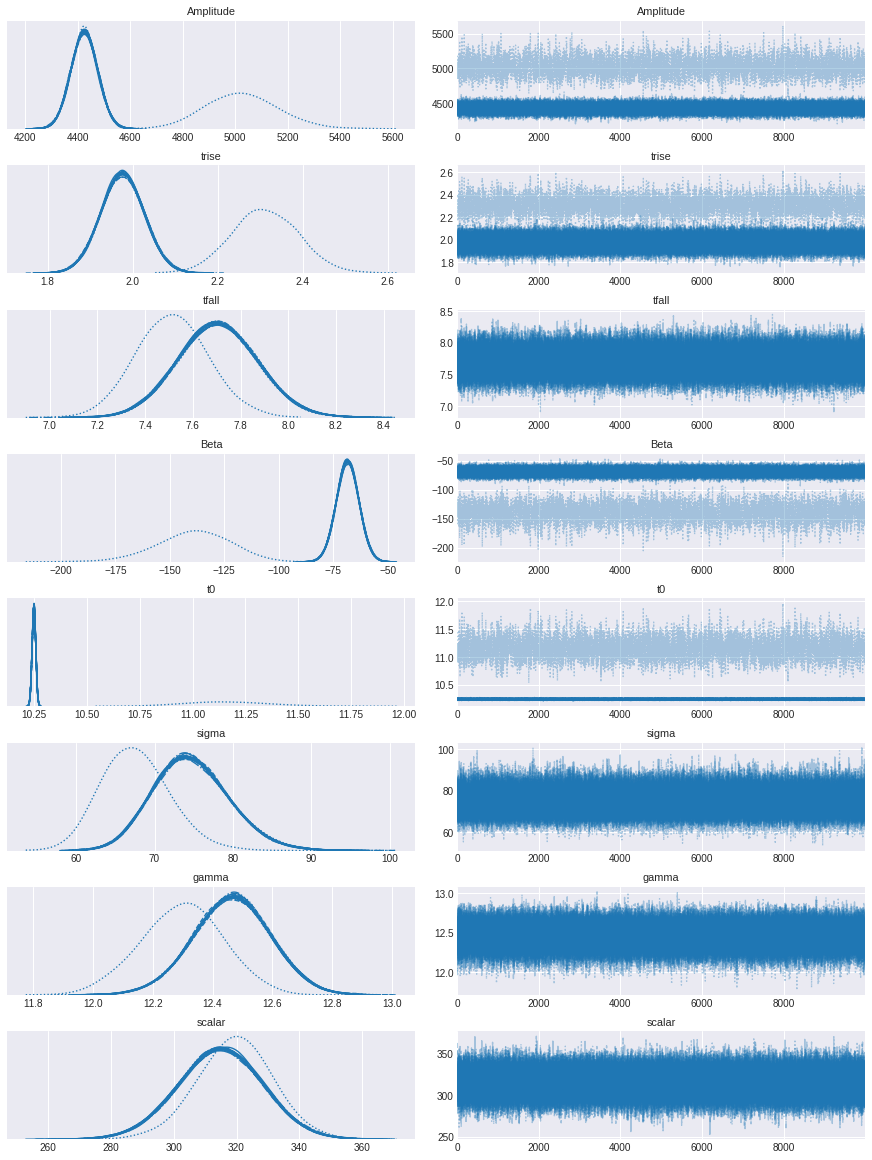

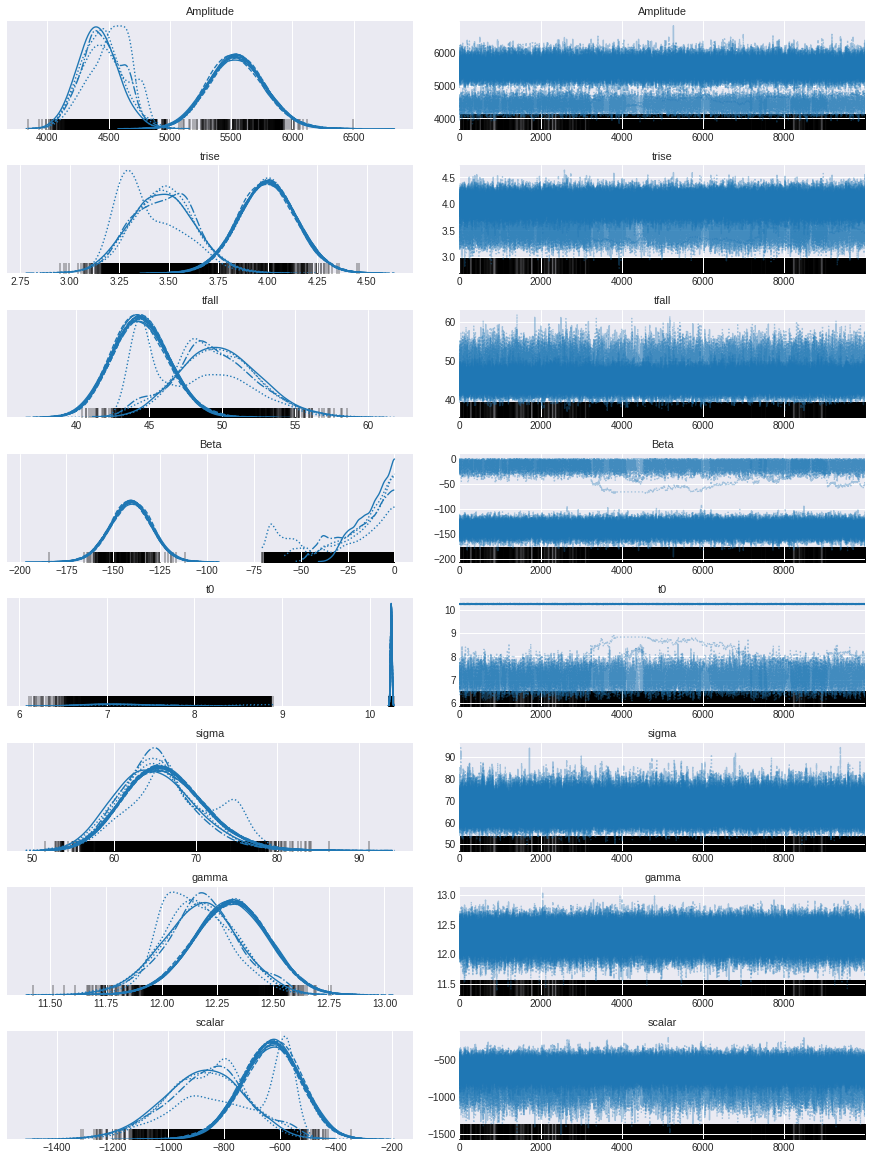

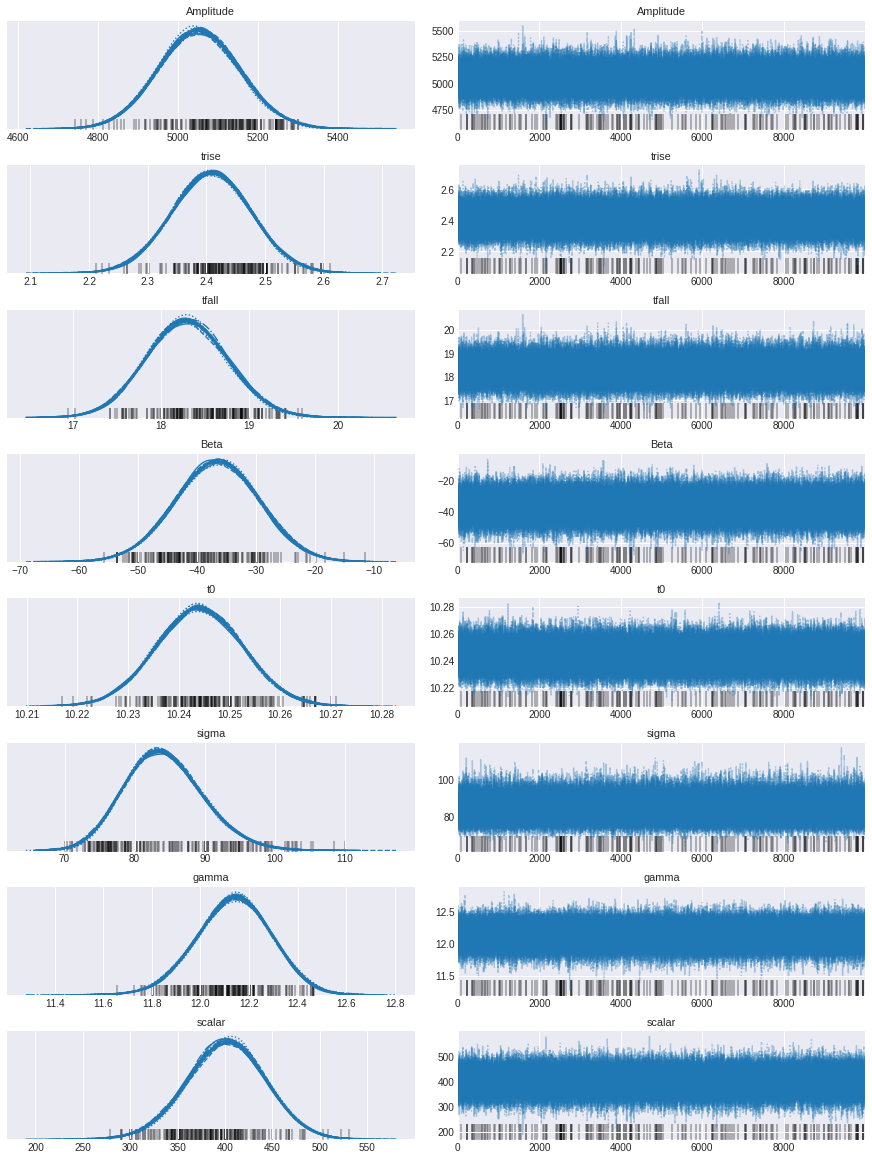

In [24]:
for i in trace_all:
    pm.traceplot(i)

In [25]:
summary_tables = []
for i in trace_all:
    summary_tables.append(pm.summary(i))

In [26]:
summary_tables[0]

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Amplitude,4456.207,142.862,4298.259,4550.745,29.321,21.081,24.0,24.0,89.0,20.0,1.14
trise,1.993,0.090,1.848,2.105,0.016,0.012,30.0,29.0,89.0,21.0,1.14
tfall,7.696,0.168,7.379,8.012,0.009,0.006,352.0,352.0,349.0,415.0,1.03
Beta,-71.939,16.593,-81.095,-55.333,3.447,2.479,23.0,23.0,89.0,20.0,1.14
t0,10.294,0.204,10.226,10.269,0.045,0.032,21.0,21.0,89.0,20.0,1.14
sigma,74.397,4.980,65.006,83.794,0.344,0.243,210.0,210.0,198.0,136.0,1.06
gamma,12.457,0.133,12.211,12.712,0.008,0.006,278.0,278.0,297.0,286.0,1.04
scalar,315.111,13.131,290.160,339.624,0.044,0.031,88140.0,88120.0,88001.0,125451.0,1.00


In [27]:
lnp = []
for j in range(len(trace_all)):
    logp = combined_model[0].logp
    lnp.append(np.array([logp(trace_all[j].point(i,chain=c)) for c in trace_all[j].chains for i in range(len(trace_all[j]))]))
    print(j)

0
1
2


In [28]:
trace_all[0].get_values("t0")[np.argmax(lnp)]

10.246917546196736

In [29]:
trise_R = []
tfall_R = []
Amplitude_R = []
Beta_R = []
t0_R = []
gamma_R = []
scalar_R = []
for i in range(len(trace_all)):
    index = np.argmax(lnp[i])
    print(index)
    trise_R.append(trace_all[i].get_values("trise")[index])
    tfall_R.append(trace_all[i].get_values("tfall")[index])
    Amplitude_R.append(trace_all[i].get_values("Amplitude")[index])
    Beta_R.append(trace_all[i].get_values("Beta")[index])
    t0_R.append(trace_all[i].get_values("t0")[index])
    gamma_R.append(trace_all[i].get_values("gamma")[index])
    scalar_R.append(trace_all[i].get_values("scalar")[index])

186220
41725
79489


In [30]:
"""
trise_R = []
tfall_R = []
Amplitude_R = []
Beta_R = []
t0_R = []
gamma_R = []
scalar_R = []
for i in summary_tables:
    trise_R.append(i["mean"]["trise"])
    tfall_R.append(i["mean"]["tfall"])
    Amplitude_R.append(i["mean"]["Amplitude"])
    Beta_R.append(i["mean"]["Beta"])
    t0_R.append(i["mean"]["t0"])
    gamma_R.append(i["mean"]["gamma"])
    scalar_R.append(i["mean"]["scalar"])
"""

'\ntrise_R = []\ntfall_R = []\nAmplitude_R = []\nBeta_R = []\nt0_R = []\ngamma_R = []\nscalar_R = []\nfor i in summary_tables:\n    trise_R.append(i["mean"]["trise"])\n    tfall_R.append(i["mean"]["tfall"])\n    Amplitude_R.append(i["mean"]["Amplitude"])\n    Beta_R.append(i["mean"]["Beta"])\n    t0_R.append(i["mean"]["t0"])\n    gamma_R.append(i["mean"]["gamma"])\n    scalar_R.append(i["mean"]["scalar"])\n'

In [31]:
print(trise_R)
print(tfall_R)
print(Amplitude_R)
print(Beta_R)
print(t0_R)
print(gamma_R)
print(scalar_R)

[1.9774891908365562, 4.039246001550494, 2.3520332773332155]
[7.727303021495113, 42.870094662172455, 17.05297102036078]
[4425.92974060656, 5492.599760697688, 4766.707931246108]
[-68.03617777551555, -135.95065261422087, -21.78311950423238]
[10.246917546196736, 10.250828495086632, 10.230243526353808]
[12.435312516282544, 12.397091452627693, 12.21653552081767]
[314.23944254759306, -591.848649819886, 534.3524479478988]


Text(0, 0.5, 'y_observed')

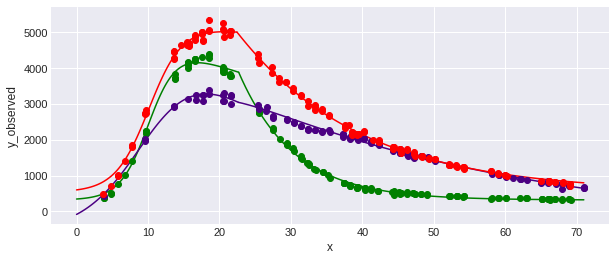

In [32]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,4))
colours = ["green", "indigo", "red"]

for i in range(filter_number):
    big_time_axis_rise = np.linspace(0,t0_R[i]+gamma_R[i],num = 100)
    ax.plot(big_time_axis_rise, SuperNova_CurveRise_Scalar(big_time_axis_rise, Amplitude_R[i], Beta_R[i], t0_R[i], trise_R[i], scalar_R[i]), color = colours[i])

for i in range(filter_number):
    big_time_axis_fall = np.linspace(t0_R[i]+gamma_R[i],end_A,num = 100)
    ax.plot(big_time_axis_fall, SuperNova_CurveFall_Scalar(big_time_axis_fall, Amplitude_R[i], Beta_R[i], t0_R[i], gamma_R[i], trise_R[i], tfall_R[i], scalar_R[i]), color = colours[i])

for i in range(filter_number):
    ax.errorbar(time_axis_filters[i], Y_observed_filter[i], Y_unc[i], fmt = "o", color = colours[i])
    
ax.set_xlabel('x')
ax.set_ylabel('y_observed')

Text(0, 0.5, 'Green Observed')

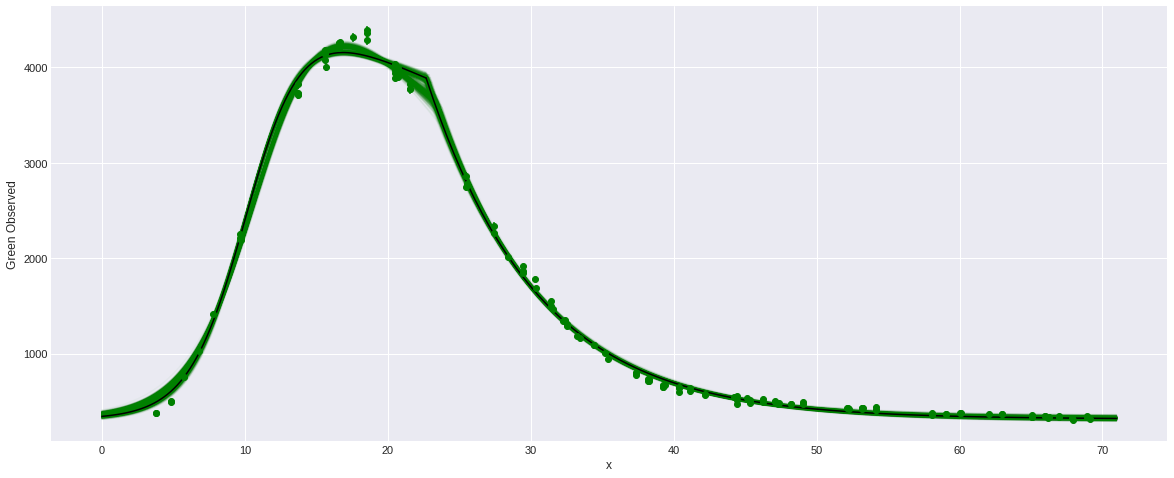

In [33]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(20,8))
colours = ["green", "indigo", "red"]

ax.errorbar(time_axis_filters[0], Y_observed_filter[0], Y_unc[0], fmt = "o", color = colours[0])

random_amount = np.random.randint(low=0, high=20000, size=1000)
trise_R_all = (trace_all[0].get_values("trise"))
tfall_R_all = (trace_all[0].get_values("tfall"))
Amplitude_R_all = (trace_all[0].get_values("Amplitude"))
Beta_R_all = (trace_all[0].get_values("Beta"))
t0_R_all = (trace_all[0].get_values("t0"))
gamma_R_all = (trace_all[0].get_values("gamma"))
scalar_R_all = (trace_all[0].get_values("scalar"))

for i in random_amount:
    big_time_axis_rise = np.linspace(0,t0_R_all[i]+gamma_R_all[i],num = 100)
    ax.plot(big_time_axis_rise, SuperNova_CurveRise_Scalar(big_time_axis_rise, Amplitude_R_all[i], Beta_R_all[i], t0_R_all[i], trise_R_all[i], scalar_R_all[i]), 'C3', alpha=.03, color = colours[0])

for i in random_amount:
    big_time_axis_fall = np.linspace(t0_R_all[i]+gamma_R_all[i],end_A,num = 100)
    ax.plot(big_time_axis_fall, SuperNova_CurveFall_Scalar(big_time_axis_fall, Amplitude_R_all[i], Beta_R_all[i], t0_R_all[i], gamma_R_all[i], trise_R_all[i], tfall_R_all[i], scalar_R_all[i]), 'C3', alpha=.03, color = colours[0])
    
big_time_axis_rise = np.linspace(0,t0_R[0]+gamma_R[0],num = 100)
ax.plot(big_time_axis_rise, SuperNova_CurveRise_Scalar(big_time_axis_rise, Amplitude_R[0], Beta_R[0], t0_R[0], trise_R[0], scalar_R[0]), color = "black")

big_time_axis_fall = np.linspace(t0_R[0]+gamma_R[0],end_A,num = 100)
ax.plot(big_time_axis_fall, SuperNova_CurveFall_Scalar(big_time_axis_fall, Amplitude_R[0], Beta_R[0], t0_R[0], gamma_R[0], trise_R[0], tfall_R[0], scalar_R[0]), color = "black")
    
ax.set_xlabel('x')
ax.set_ylabel('Green Observed')